In [1]:
%load_ext autoreload
%autoreload 2

import json
import re
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

seed = 42
video_path = 'data_generated/R25_gray_scaled.mp4'

video = VideoLoader(video_path, duration=30, gray=True)
meta = {'w': video.width,
        'h': video.height,
        'fps': video.fps,
        'bs': video.batch_size,
        'gray': video.gray}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Device:',torch.cuda.get_device_name(device))
models = torch.load('data_generated/week7/models.pth', map_location=device)

# Convert TempConvAE's weights
d = models['10-TempConvAE']['model']
d["to_lower_rep.weight"] = d["low_dim_mapping.0.weight"]
d["to_lower_rep.bias"] =   d["low_dim_mapping.0.bias"]
d["from_lower_rep.weight"] = d["low_dim_mapping.1.weight"]
d["from_lower_rep.bias"] = d["low_dim_mapping.1.bias"]
del d["low_dim_mapping.0.weight"]
del d["low_dim_mapping.0.bias"]
del d['low_dim_mapping.1.weight']
del d['low_dim_mapping.1.bias']
del models['10-OneHAE']['little_modification']

Device: Tesla P100-PCIE-12GB


## JIGSAWS

Useful variables created:
- `i2act` and `act2i`
- `nact`, `nvideo_per_act[_train, _test]`
- `videos[_train, _test]`
- `video_durations`
- `test_set_indices`

In [2]:
i2act = {0: 'Knot_Tying',
        1: 'Needle_Passing',
        2: 'Suturing'}
nact = len(i2act.keys())
act2i = {v: k for k, v in i2act.items()}

### Scale the videos

In [ ]:
root_path = 'data/JIGSAWS'
videos = []
for i in range(nact):
    videos.append([])
    activity_name = i2act[i]
    names = !find "$root_path/$activity_name/video" -type f
    for name in names:
        video = VideoLoader(name, gray=True, scale=(256, 256))
        videos[i].append(video)

In [ ]:
videos_flat = [v for vs in videos for v in vs]

for v in videos_flat:
    new_name = re.sub(root_path, root_path+'_converted', v.filename)
    new_name_dir = re.sub('[^/]+$', '', new_name)
    ![ -d $new_name_dir ] || mkdir -p $new_name_dir

    v.write(new_name)

In [ ]:
nfiles = !find $root_path"_converted" -type f | grep -v '.*zip' | wc -l
assert len(videos_flat) == int(nfiles[0])

### Load videos and splitting into train set and test set

As we can see below, each activity's total duration is `1:08:40`. We give `20%` of the data to the test set.

In [3]:
root_path = 'data/JIGSAWS_converted'
videos = []
video_names = []
video_durations = []
for i in range(nact):
    videos.append([])
    video_durations.append([])
    activity_name = i2act[i]
    names = !find "$root_path/$activity_name/video" -type f
    video_names.append(names)
    for name in names:
        if re.match('.*\.avi', name) is None:
            print(f'{name} is not an avi file.')
            continue
        video = VideoLoader(name, gray=True, scale=(256, 256))
        videos[i].append(video)
        video_durations[i].append(video.duration)
video_durations = [np.array(durations) for durations in video_durations]

In [4]:
nvideo_per_act = [len(vs) for vs in video_durations]
for i, act_videos in enumerate(videos):
    for j, v in enumerate(act_videos):
        video_durations[i][j] = v.duration
    print('Activity:', i2act[i])
    print('\tTotal duration:', sec2string(np.sum(video_durations[i])))
    print('\tNumber of videos:', len(video_durations[i]))

Activity: Knot_Tying
	Total duration: 1:07:18
	Number of videos: 72
Activity: Needle_Passing
	Total duration: 1:40:16
	Number of videos: 56
Activity: Suturing
	Total duration: 2:25:02
	Number of videos: 78


In [5]:
"""
    Source: https://nerderati.com/2014/08/19/bartering-for-beers-with-approximate-subset-sums/

    DOES NOT WORK: the algorithm can take multiple times the same index
"""
import itertools
import operator

def merge_lists(m, n):
    """
    Merges two lists into one.

    We do *not* remove duplicates, since we'd like to see all possible
    item combinations for the given approximate subset sum instead of simply
    confirming that there exists a subset that satisfies the given conditions.

    """
    merged = itertools.chain(m, n)
    return sorted(merged, key=operator.itemgetter('value'))

def trim(data, delta):
    """Trims elements within `delta` of other elements in the list."""

    output = []
    last = 0

    for element in data:
        if element['value'] > last * (1 + delta):
            output.append(element)
            last = element['value']

    return output

def approximate_subset_sum(data, target, epsilon):
    """
    Calculates the approximate subset sum total in addition
    to the items that were used to construct the subset sum.

    Modified to track the elements that make up the partial
    sums to then identify which subset items were chosen
    for the solution.

    """

    # Intialize our accumulator with the trivial solution
    acc = [{'value': 0, 'partials': [0]}]

    count = len(data)

    # Prep data by turning it into a list of hashes
    data = [{'value': d, 'partials': [d]} for d in data]

    for key, element in enumerate(data, start=1):
        augmented_list = [{
            'value': element['value'] + a['value'],
            'partials': a['partials'] + [element['value']]
        } for a in acc]

        acc = merge_lists(acc, augmented_list)
        acc = trim(acc, delta=float(epsilon) / (2 * count))
        acc = [val for val in acc if val['value'] <= target]

    # The resulting list is in ascending order of partial sums; the
    # best subset will be the last one in the list.
    return acc[-1]

# Find how to split each activity
test_ratio = 0.2
test_set_indices = []
train_set_indices = []
for i in range(nact):
    app_sum = approximate_subset_sum(video_durations[i],
                                      test_ratio*np.sum(video_durations[i]), 0.5)
    partials = app_sum['partials']
    test_set_indices.append([])
    for val in partials[1:]:
        test_set_indices[i].append(np.argwhere(np.array(video_durations[i])==val)[0,0])
    test_set_indices[i] = np.array(test_set_indices[i])
    all_i = np.arange(test_set_indices[i].shape[0])
    train_set_indices.append(all_i[~np.in1d(all_i, test_set_indices[i])])


In [6]:
# Manual creation of test/train split
test_set_indices = []
test_set_indices.append(np.array(list(range(12))+[24]))
test_set_indices.append(np.array(list(range(11))+[19]))
test_set_indices.append(np.array(list(range(15))+[46]))

train_set_indices = []
for i in range(nact):
    all_i = np.arange(nvideo_per_act[i])
    train_set_indices.append(all_i[~np.in1d(all_i, test_set_indices[i])])

# Verify the ratio
for i in range(nact):
    test_duration = 0
    for j in test_set_indices[i]:
        test_duration += video_durations[i][j]
    test_ratio = test_duration/np.sum(video_durations[i])
    print(f'Test ratio for {i2act[i]}:', test_ratio)

# Split each activity
videos_train = []
videos_test = []
nvideo_per_act_train = []
nvideo_per_act_test = []
for i in range(nact):
    videos_train.append([])
    videos_test.append([])
    nvideo_per_act_train.append(0)
    nvideo_per_act_test.append(0)
    for j, v in enumerate(videos[i]):
        if j in test_set_indices[i]:
            videos_test[i].append(v)
            nvideo_per_act_test[i] += 1
        else:
            videos_train[i].append(v)
            nvideo_per_act_train[i] += 1

Test ratio for Knot_Tying: 0.19968304278922344
Test ratio for Needle_Passing: 0.2
Test ratio for Suturing: 0.20004903162539836


### Fit models

In [7]:
ncomp = 10
all_models = {}

#### Baseline for each videos separately

In [8]:
all_models = torch.load('data_generated/individual_video_models.pth')

In [8]:
all_models['baseline'] = []
models = all_models['baseline']
for act in range(nact):
    models.append([])
    print('Fitting activity', i2act[act])
    for video in videos_train[act]:
        video.torch = False
        all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

        model_compression = custom_pca(ncomp)
        model_compression.fit(all_frames)
        frames_enc, shape = model_compression.encode(all_frames)
        A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]
        model_ds = A

        models[act].append((model_compression, model_ds))

Fitting activity Knot_Tying
Fitting activity Needle_Passing
Fitting activity Suturing


In [11]:
torch.save(all_models, 'data_generated/individual_video_models.pth')

In [10]:
models = all_models['baseline']
act_comb = [(i, j) for i in range(nact) for j in range(nact) if i >= j]
dists = {}
nmodel_subsample = 10
for dist_func, dist_name in [(martin_dist, 'Martin'), (frob_dist, 'Frobenius')]:
    dists[dist_name] = {}
    for i, j in act_comb:
        key = i2act[i]+'-'+i2act[j]

        # Take subsample of models at random
        act1_vids = np.random.choice(np.arange(nvideo_per_act_train[i]), size=nmodel_subsample, replace=False)
        act2_vids = np.random.choice(np.arange(nvideo_per_act_train[j]), size=nmodel_subsample, replace=False)
        model_combinations = np.array([[i, j] for i in act1_vids for j in act2_vids])
        model_combinations = [(models[i][k], models[j][l]) for k, l in model_combinations]

        dists[dist_name][key] = np.zeros(len(model_combinations))
        for comb, (m1, m2) in enumerate(model_combinations):
            dists[dist_name][key][comb] = dist_func(subspace_angles(m1, m2))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/work/test/utils.py:200: RuntimeWarning: invalid value encountered in arccos
  eigens = np.arccos(np.sqrt(eigens))


Knot_Tying-Knot_Tying Knot_Tying-Knot_Tying 33.14785314320329 12.023174670315703
Needle_Passing-Needle_Passing Needle_Passing-Needle_Passing 38.13489905865225 13.471065707333654
Knot_Tying-Knot_Tying Knot_Tying-Knot_Tying nan nan
Needle_Passing-Needle_Passing Needle_Passing-Needle_Passing 26.311424594624608 6.6618494611391075


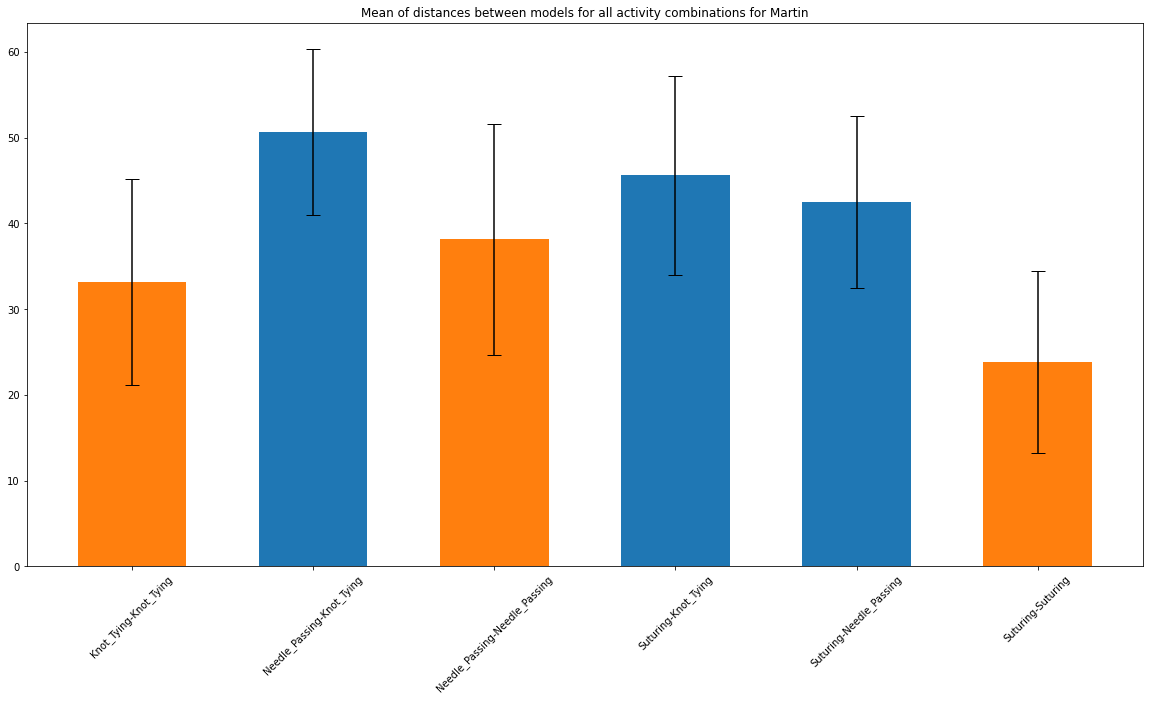

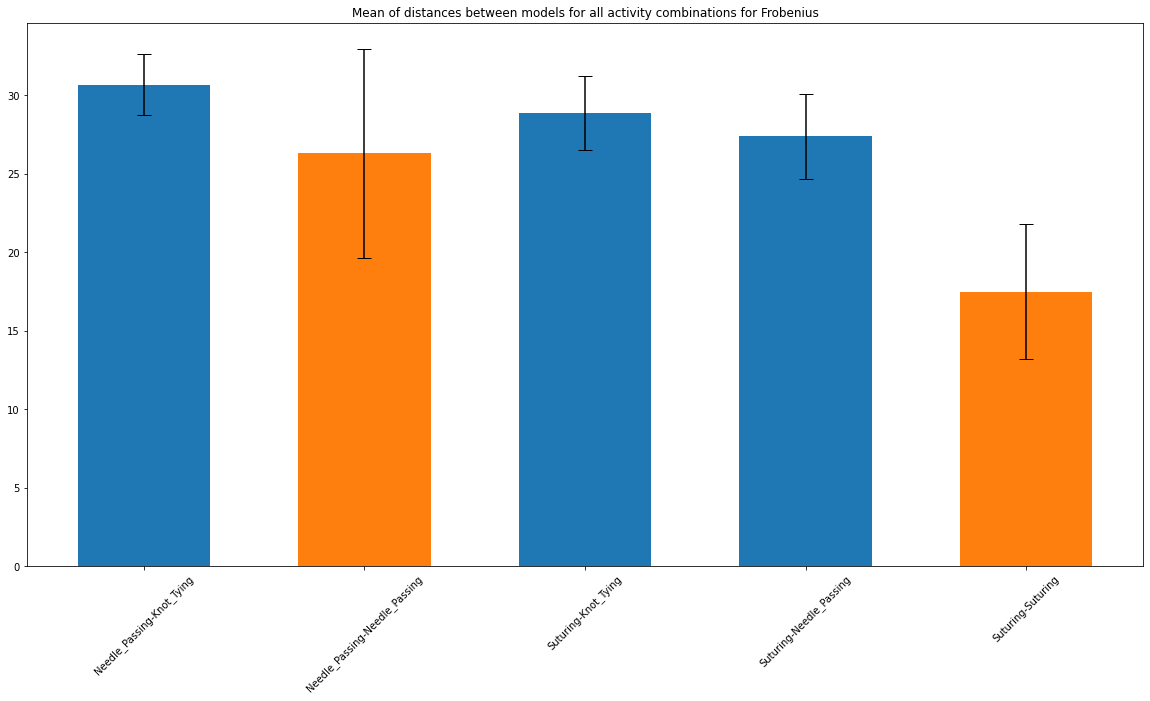

In [11]:
for dist in ['Martin', 'Frobenius']:
    x = []
    y_mean = []
    y_std = []
    for i, j in act_comb:
        key = i2act[i]+'-'+i2act[j]
        dist_values = dists[dist][key]
        x.append(key)
        y_mean.append(np.mean(dist_values))
        y_std.append(np.std(dist_values))
        if (i, j) == (0, 0) or (i,j)==(1,1):
            print(key, x[-1], y_mean[-1], y_std[-1])

    colors = ['tab:orange' if i == j else 'tab:blue' for i, j in act_comb]
    plt.figure(figsize=(20, 10))
    plt.title('Mean of distances between models for all activity combinations for '+dist)
    plt.xticks(rotation=45)
    plt.bar(x, y_mean, width=0.6, color=colors, yerr=y_std, capsize=7)

#### Baseline for all videos jointly

In [17]:
act = 0
all_frames = []
for video in videos_train[act]:
    video.torch = False
    all_frames.append(video.get_all_frames().reshape(video.duration_frames, -1))

In [ ]:
all_frames = np.vstack(all_frames)

#### PCA autoencoder

In [ ]:
all_models['PCAAE'] = []
models = all_models['PCAAE']
for act in range(nact):
    models.append([])
    print('Activity', i2act[act],':')
    for video in videos_train[act]:
        print(f'Fitting {re.sub(f'{root_path}/.*/video/', '', video.filename)}:')


        models[nact].append((model_compression, model_ds))

## Compression models

In [2]:
def compression_train_helper(model_key, base_model, model_args, video, lrs, models, num_epoch_tune=10, num_epoch=40):
    iteration_per_epoch = int(video.duration_frames/video.batch_size)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device', device)
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))

    losses_tune = []
    for lr in lrs:
        if len(lrs) == 1:
            losses_tune.append(0)
            break
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = base_model(*model_args).to(device)
        optimizer = Adam(model.parameters(), lr=lr)
        for epoch in range(num_epoch_tune):
            epoch_loss = 0
            for frames in video:
                frames = frames.to(device)
                reconstructed = model(frames)
                loss = crit(frames, reconstructed)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
        losses_tune.append(epoch_loss / iteration_per_epoch)
        if len(losses_tune) >= 2 and losses_tune[-1] > losses_tune[-2]:
            break
    lr = lrs[np.argmin(losses_tune)]
    print('Chosen learning rate:', lr)
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = base_model(*model_args).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    t1 = time()
    losses = []
    for epoch in range(num_epoch):
        epoch_loss = 0
        for frames in video:
            frames = frames.to(device)
            reconstructed = model(frames)
            loss = crit(frames, reconstructed)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / iteration_per_epoch)
        if (epoch+1) % 3 == 0:
            print(f'\t Error at epoch {epoch+1}:', losses[-1])

    model_dict = {
        'model': model.state_dict(),
        'epoch': num_epoch,
        'optimizer': optimizer.state_dict(),
        'lr': lr,
        'losses_tune': losses_tune,
        'lrs': lrs,
        'losses': losses,
        'epoch_time': (time()-t1)/num_epoch
    }
    models[model_key] = model_dict
    return model

def evaluate_model(model, model_key, models, meta):
    reconstructed_train = video_train.reduce_latent(model, trans=False)
    reconstructed_test = video_test.reduce_latent(model, trans=False)
    original_frames_train_ = original_frames_train.numpy().reshape(-1, *video_train.sample_shape)
    original_frames_test_  = original_frames_test.numpy().reshape(-1, *video_test.sample_shape)
    models[key]['train_error'] = reconstruction_error(original_frames_train_, reconstructed_train.numpy())
    models[key]['test_error'] = reconstruction_error(original_frames_test_, reconstructed_test.numpy())
    print('Training error:', models[key]['train_error'])
    print('Testing error:', models[key]['test_error'])
    reconstructed_train_ = reconstructed_train.numpy().reshape(-1, video_train.height, video_train.width)
    write_video(key+'.mp4', reconstructed_train_, meta['w'], meta['h'], meta['fps'], meta['gray'])
    print('Video for '+key+' written')

video_train = VideoLoader(video_path, duration=30, gray=True)
video_test =  VideoLoader(video_path, start=30, duration=10, gray=True)
meta = {'w': video_train.width,
        'h': video_train.height,
        'fps': video_train.fps,
        'bs': video_train.batch_size,
        'gray': video_train.gray}
original_frames_train = video_train.get_all_frames()
original_frames_test = video_test.get_all_frames()
num_epoch, num_epoch_tune = 40, 10

_ = """
############   PCA autoencoder   ############
lrs = [1e-05, 5e-05, 1e-04]
key = '50-PCAAE'
print('\nModel', key)
video_train.sample_shape = video_test.sample_shape = (1, meta['h'], meta['w'])
model = compression_train_helper(key, PCAAutoEncoder, ((1, meta['w'], meta['h']), 50), video_train,
                           lrs, models, num_epoch=50)

evaluate_model(model, key, models, meta)

############ One hidden layer AE ############
key = '10-OneHAE'
print('\nModel', key)
lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
video_train.sample_shape = video_test.sample_shape = (1, meta['h'], meta['w'])
model = compression_train_helper(key, OneHAutoEncoder, ((1, meta['h'], meta['w']), 10), video_train,
                          lrs, models)

evaluate_model(model, key, models, meta)

############   Temporal Conv AE   ############
key = 'TempConvAE'
print('\nModel', key)
video_train.sample_shape = video_test.sample_shape = (1, 16, meta['h'], meta['w'])
model = compression_train_helper(key, TemporalConvAE, (1, 2, 32), video_train, lrs, models)

evaluate_model(model, key, models, meta)

############  160-Temporal Conv AE  ############
key = '10-TempConvAE'
print('\nModel', key)
video_train.sample_shape = video_test.sample_shape = (1, 16, meta['h'], meta['w'])
model = train_helper(key, TemporalConvAE, (1, 2, 32, 160), video_train, lrs, models)

evaluate_model(model, key, models, meta)
"""

## Classification algorithm

#### Model comparison

A model is a tuple: the compression model and the dynamical system. The compression model is either a model with a `C` attribute being the matrix of projection or a non-linear compression model in which case the `C` matrix associated with it will be $I_{p \times n}$

For now the bias in the dynamical system are ignored

In [160]:
# Model definition

## Baseline, separated learning
video.torch = False
all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

model_pca = custom_pca(10)
model_pca.fit(all_frames)
frames_enc, shape = model_pca.encode(all_frames)
A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]
model1 = (model_pca, A)

## Baseline as autoencoder (Created and trained below)
model2 = (model, model_ds)

subspace_angles(model1, model2, A2_key='predictor.weight', C2_key='from_lower_rep.weight')

array([0.058563  , 0.038213  , 0.03299011, 0.03039991, 0.02452698,
       0.01096707, 0.01312446, 0.01989882, 0.01622211, 0.01752454,
       0.058563  , 0.038213  , 0.03299011, 0.03039991, 0.02452698,
       0.01096707, 0.01312446, 0.01989882, 0.01622211, 0.01752454])

## Dynamical system models

### Baseline

In [137]:
video.torch = False
all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

model_pca = custom_pca(10)
model_pca.fit(all_frames)

In [138]:
frames_enc, shape = model_pca.encode(all_frames)
A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]
print(frames_enc.shape, A.shape)

(960, 10) (10, 10)


In [139]:
Y_pred = model_pca.decode(frames_enc[:-1]@A)
error_pca = reconstruction_error(Y_pred, all_frames[1:])
print('Error on prediction:', error_pca)
print('Error on reconstruction:', reconstruction_error(all_frames, model_pca.decode(frames_enc)))

Error on prediction: 8.326775
Error on reconstruction: 8.126883


### PCA jointly optimized, initialized with the baseline transformation

In [140]:
class FramePredictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.predictor = nn.Linear(model.ncomp, model.ncomp)

    def forward(self, x):
        shape = x.shape
        x = self.predictor(x.view(x.shape[0], -1))

        return x.view(shape)

#### Initialization as PCA

In [141]:
video = VideoLoader(video_path, duration=30, gray=True)
iteration_per_epoch = int(video.duration_frames/video.batch_size)
model = PCAAutoEncoder((1, meta['h'], meta['w']), 10).to(device)

state_dict = model.state_dict()
state_dict['to_lower_rep.weight'] = torch.from_numpy(model_pca.C.T).to(device)
state_dict['to_lower_rep.bias'] = torch.zeros_like(state_dict['to_lower_rep.bias'])
state_dict['from_lower_rep.weight'] = torch.from_numpy(model_pca.C).to(device)
state_dict['from_lower_rep.bias'] = torch.zeros_like(state_dict['from_lower_rep.bias'])
model.load_state_dict(state_dict)
model_ds = FramePredictor(model).to(device)
state_dict = model_ds.state_dict()
state_dict['predictor.weight'] = torch.from_numpy(A.T).to(device)
state_dict['predictor.bias'] = torch.zeros_like(state_dict['predictor.bias'])
model_ds.load_state_dict(state_dict)
mean,std = model_pca.mean, model_pca.std

#### Verification of the error

In [8]:
frames_rec = []
for frames in video:
    frames = standardize_frames(frames, mean=model_pca.mean, std=model_pca.std).to(device)
    frames_rec.append(model(frames))
frames_rec = torch.cat(frames_rec, 0)*model_pca.std+model_pca.mean

print('Error on reconstruction:', crit(frames_rec.squeeze().to('cpu'), video.get_all_frames()).item())

Error on reconstruction: 8.105321884155273


In [9]:
frames_pred = []
for frames in video:
    frames = standardize_frames(frames, mean=model_pca.mean, std=model_pca.std).to(device)
    enc = model.encode(frames)
    frames_pred.append(model.decode(model_ds(enc)))
frames_pred = torch.cat(frames_pred, 0)*model_pca.std+model_pca.mean
frames_pred = frames_pred[:-1]

print('Error on prediction:', crit(frames_pred.squeeze().to('cpu'), video.get_all_frames()[1:]).item())

Error on prediction: 8.305706024169922


#### Fine-tuning of the model

Epoch 1: 8.1148832321167
Epoch 6: 8.06935354868571
Epoch 11: 8.062978903452555
Epoch 16: 8.061997191111248


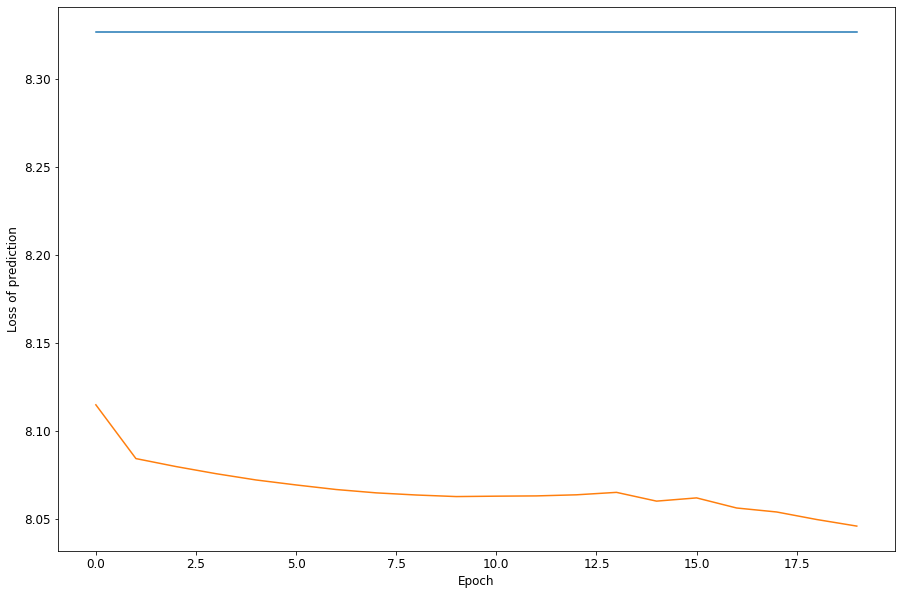

In [142]:
# Joint training
np.random.seed(seed)
torch.manual_seed(seed)
optimizer_both = Adam(list(model.parameters())+list(model_ds.parameters()), lr=0.00001)

losses_pcaae = []
for epoch in range(20):
    epoch_loss = 0
    for frames in video:
        frames = frames.to(device)
        frames_std = standardize_frames(frames, mean=mean, std=std)
        frames_next_gt = frames[1:]
        frames_enc = model.encode(frames_std[:-1])
        frames_next_std = model.decode(model_ds(frames_enc))
        frames_next = frames_next_std*std + mean

        loss = crit(frames_next, frames_next_gt)
        epoch_loss += loss.item()

        optimizer_both.zero_grad()
        loss.backward()
        optimizer_both.step()
    losses_pcaae.append(epoch_loss/iteration_per_epoch)
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}:', epoch_loss/iteration_per_epoch)
plot(range(20), [20*[8.326775], losses_pcaae], xlabel='Epoch', ylabel='Loss of prediction')

### Using OneH network for compression

#### One hidden layer autoencoder with initialization as after training of compression model

Training transition matrix
Epoch 1: 128.7869074503581
Epoch 6: 14.27553939819336
Training transition matrix and compression model
Epoch 11: 64.07721532185873 (optimizing compression model)
Epoch 16: 15.054534339904786 (optimizing dynamical system)
Epoch 21: 15.604681015014648 (optimizing compression model)
Epoch 26: 14.407950973510742 (optimizing dynamical system)
Epoch 31: 14.294347890218098 (optimizing compression model)
Epoch 36: 13.958980178833007 (optimizing dynamical system)
Epoch 41: 13.951625951131184 (optimizing compression model)
Epoch 46: 13.742918777465821 (optimizing dynamical system)
Epoch 51: 13.756185658772786 (optimizing compression model)


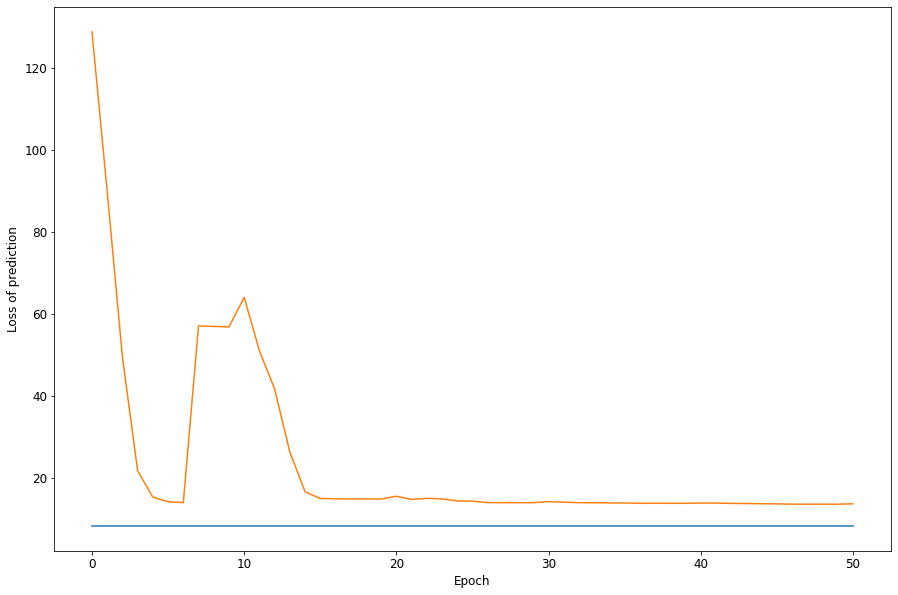

In [68]:
np.random.seed(seed)
torch.manual_seed(seed)
video = VideoLoader(video_path, duration=30, gray=True)
iteration_per_epoch = int(video.duration_frames/video.batch_size)

model = OneHAutoEncoder((1, meta['h'], meta['w']), 10)
model.load_state_dict(models['10-OneHAE']['model'])
model.to(device)
model_ds = FramePredictor(model).to(device)
optimizer_ds = Adam(model_ds.parameters(), lr=0.005)

losses_oneh = []
epoch_ds, epoch_tot = 7, 51
print('Training transition matrix')
for epoch in range(epoch_ds):
    epoch_loss = 0
    for frames in video:
        frames = frames.to(device)
        frames_next_gt = frames[1:]
        frames_enc = model.encode(frames[:-1])
        frames_next = model.decode(model_ds(frames_enc))

        loss = crit(frames_next.squeeze(), frames_next_gt)
        epoch_loss += loss.item()

        optimizer_ds.zero_grad()
        loss.backward()
        optimizer_ds.step()
    losses_oneh.append(epoch_loss/iteration_per_epoch)
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}:', epoch_loss/iteration_per_epoch)

optimizer = Adam(model.parameters(), lr=models['10-OneHAE']['lr'])
optimizer.load_state_dict(models['10-OneHAE']['optimizer'])
optimizer_ds = Adam(model_ds.parameters(), lr=0.0005)
current_opt, current_opt_descr = optimizer_ds, 'dynamical system'
other_opt, other_opt_descr = optimizer, 'compression model'
print('Training transition matrix and compression model')
for epoch in range(epoch_ds, epoch_tot):
    epoch_loss = 0
    if epoch % 5 == 0:
        current_opt, other_opt = other_opt, current_opt
        current_opt_descr, other_opt_descr = other_opt_descr, current_opt_descr
    for frames in video:
        frames = frames.to(device)
        frames_std = standardize_frames(frames, mean=mean, std=std)
        frames_next_gt = frames[1:]
        frames_enc = model.encode(frames_std[:-1])
        frames_next_std = model.decode(model_ds(frames_enc))
        frames_next = frames_next_std*std + mean

        loss = crit(frames_next, frames_next_gt)
        epoch_loss += loss.item()

        current_opt.zero_grad()
        loss.backward()
        current_opt.step()
    losses_oneh.append(epoch_loss/iteration_per_epoch)
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}:', epoch_loss/iteration_per_epoch, f'(optimizing {current_opt_descr})')
plot(range(epoch_tot), [epoch_tot*[8.326775], losses_oneh], xlabel='Epoch', ylabel='Loss of prediction')

### Using spatio-temporal convolutional network for compression

#### Train with initialization as after training of compression model

Training transition matrix
Epoch 1: 46.305629229141495
Epoch 6: 14.932292162361792
Training transition matrix and compression model
Epoch 11: 15.25699321294235 (optimizing compression model)
Epoch 16: 15.133763814376572 (optimizing compression model)
Epoch 21: 15.039607694593526 (optimizing compression model)
Epoch 26: 14.963500459315414 (optimizing compression model)
Epoch 31: 14.899821394580906 (optimizing compression model)
Epoch 36: 14.846452405897237 (optimizing compression model)
Epoch 41: 14.801777435561357 (optimizing compression model)
Epoch 46: 14.762775776749951 (optimizing compression model)


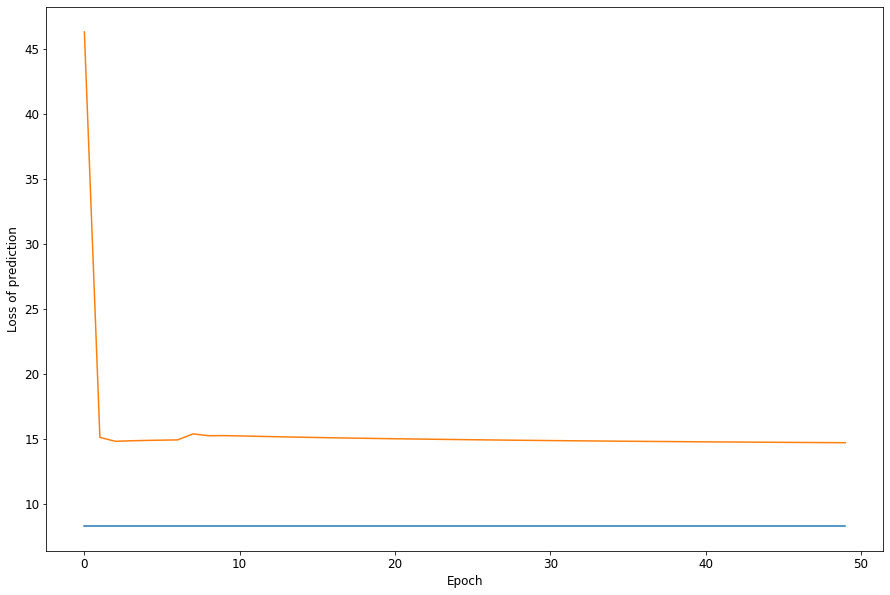

In [69]:
np.random.seed(seed)
torch.manual_seed(seed)
video.torch = True
temporal_batch_size = 16
video.sample_shape = (1, temporal_batch_size, meta['h'], meta['w'])
video.iterator_stride = 1
video.batch_size = 16
iteration_per_epoch = video.duration_frames-video.batch_size

model = TemporalConvAE(1, 2, 32, 10)
model.load_state_dict(models['10-TempConvAE']['model'])
model.to(device)
model_ds = FramePredictor(model).to(device)
optimizer = Adam(list(model.parameters())+list(model_ds.parameters()), lr=0.0001)
optimizer_ds = Adam(model_ds.parameters(), lr=0.005)

losses_tempconv = []
epoch_ds, epoch_tot = 7, 50
print('Training transition matrix')
for epoch in range(epoch_ds):
    epoch_loss = 0
    cnt = 0
    x_prev = None
    loss = 0
    for i, frames in enumerate(video):
        frames = frames.to(device)
        x = model.encode(frames)
        if x_prev is None:
            x_prev = x.detach()
            continue
        x_pred = model_ds(x_prev)
        loss = loss + crit(model.decode(x_pred), frames)
        cnt += 1
        x_pred = x.detach()

        if (i+1) % video.batch_size == 0:
            optimizer_ds.zero_grad()

            loss.backward(retain_graph=True)
            epoch_loss += loss.item()
            loss = 0
            optimizer_ds.step()
    losses_tempconv.append(epoch_loss/iteration_per_epoch)
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}:', epoch_loss/iteration_per_epoch)

print('Training transition matrix and compression model')
for epoch in range(epoch_ds, epoch_tot):
    epoch_loss = 0
    cnt = 0
    x_prev = None
    loss = 0
    for i, frames in enumerate(video):
        frames = frames.to(device)
        x = model.encode(frames)
        if x_prev is None:
            x_prev = x.detach()
            continue
        x_pred = model_ds(x_prev)
        loss = loss + crit(model.decode(x_pred), frames)
        cnt += 1
        x_pred = x.detach()

        if (i+1) % video.batch_size == 0:
            optimizer.zero_grad()

            loss.backward(retain_graph=True)
            epoch_loss += loss.item()
            loss = 0
            optimizer.step()

    losses_tempconv.append(epoch_loss/iteration_per_epoch)
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}:', epoch_loss/iteration_per_epoch, f'(optimizing {current_opt_descr})')
"""

optimizer = Adam(model.parameters(), lr=models['10-TempConvAE']['lr'])
optimizer.load_state_dict(models['10-TempConvAE']['optimizer'])
optimizer_ds = Adam(model_ds.parameters(), lr=0.0005)
current_opt, current_opt_descr = optimizer_ds, 'dynamical system'
other_opt, other_opt_descr = optimizer, 'compression model'
for epoch in range(num_epoch):
    epoch_loss = 0
    if epoch % 5 == 0:
        current_opt, other_opt = other_opt, current_opt
        current_opt_descr, other_opt_descr = other_opt_descr, current_opt_descr

    epoch_loss = 0
    cnt = 0
    x_prev = None
    loss = 0
    for i, frames in enumerate(video):
        frames = frames.to(device)
        x = model.encode(frames)
        if x_prev is None:
            x_prev = x.detach()
            continue
        x_pred = model_ds(x_prev)
        loss = loss + crit(model.decode(x_pred), frames)
        cnt += 1
        x_pred = x.detach()

        if (i+1) % video.batch_size == 0:
            #print(next(model.parameters())[0,0,0,0], next(model_ds.parameters())[0,0])
            #print(i)
            optimizer.zero_grad()

            loss.backward(retain_graph=True)
            epoch_loss += loss.item()
            loss = 0
            optimizer.step()

    print(epoch_loss/iteration_per_epoch)
"""
plot(range(epoch_tot), [epoch_tot*[8.326775], losses_tempconv], xlabel='Epoch', ylabel='Loss of prediction')

## Save losses

In [73]:
losses = {}
for k, v in [('10-PCAAE', losses_pcaae), ('10-OneHAE', losses_oneh), ('10-TempConvAE', losses_tempconv)]:
    losses[k] = v
torch.save(losses, 'data_generated/week8/losses.pth')